In [5]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, classification_report, SCORERS, log_loss
#####################################################################################################################
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 10, 6
############################################### load data ############################################################
RANDOM_SEED = 42
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', header = None, names = columns, on_bad_lines='skip')
df = df.dropna()
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086465 entries, 0 to 1086465
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1086465 non-null  int64  
 1   activity   1086465 non-null  object 
 2   timestamp  1086465 non-null  int64  
 3   x-axis     1086465 non-null  float64
 4   y-axis     1086465 non-null  float64
 5   z-axis     1086465 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.0+ MB


In [6]:
N_TIME_STEPS = 90
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)
X_train = tf.expand_dims(X_train, axis=-1)

In [7]:
N_CLASSES = 6
BATCH_SIZE = 64
LEARNING_RATE = 0.0025
N_EPOCHS = 50 #50
########################################################################################################################
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, Flatten
from keras.layers import Dropout
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))


In [8]:
model.add(Dense(units=6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 50
batch_size = 1024

In [9]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

2022-04-20 18:38:33.010888: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50
39/39 [==============================] - 1s 23ms/step - loss: 1.5574 - accuracy: 0.3294 - val_loss: 1.5080 - val_accuracy: 0.2566
Epoch 2/50
39/39 [==============================] - 1s 22ms/step - loss: 1.4862 - accuracy: 0.3711 - val_loss: 1.4586 - val_accuracy: 0.3863
Epoch 3/50
39/39 [==============================] - 1s 23ms/step - loss: 1.4380 - accuracy: 0.3998 - val_loss: 1.4108 - val_accuracy: 0.6351
Epoch 4/50
39/39 [==============================] - 1s 23ms/step - loss: 1.3932 - accuracy: 0.6573 - val_loss: 1.3675 - val_accuracy: 0.6597
Epoch 5/50
39/39 [==============================] - 1s 22ms/step - loss: 1.3479 - accuracy: 0.6663 - val_loss: 1.3229 - val_accuracy: 0.6691
Epoch 6/50
39/39 [==============================] - 1s 23ms/step - loss: 1.3067 - accuracy: 0.6694 - val_loss: 1.2836 - val_accuracy: 0.6700
Epoch 7/50
39/39 [==============================] - 1s 22ms/step - loss: 1.2709 - accuracy: 0.6703 - val_loss: 1.2514 - val_accuracy: 0.6694
Epoch 8/50
39

340/340 [==============================] - 0s 1ms/step - loss: 0.4993 - accuracy: 0.8217
Test set
  Loss: 0.499
  Accuracy: 0.822


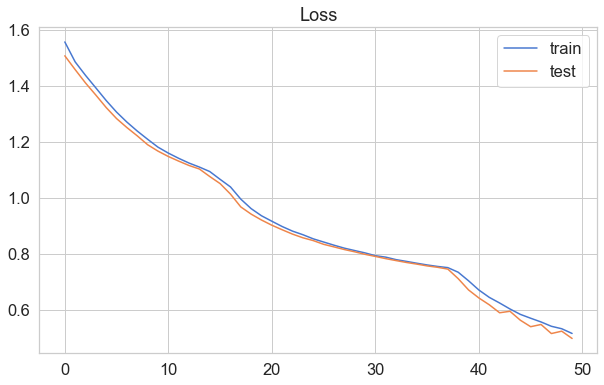

In [10]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [11]:
model.save('models/CNNv1')

2022-04-20 18:40:35.292822: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/CNNv1/assets
